<a href="https://colab.research.google.com/github/sramponi86/CAS_AIS_first_models/blob/main/W2_4_1_Pretrained_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with a Pretrained Model
In this notebook, we look at text classification again, but will start with a pre-trained BERT model to get an encoding (i.e., a representation).

We will work with a distilbert model, which has similar performance as a full BERT model, but which is more compact (i.e., *distilled*). Also, we will use an uncased version, such that upper and lower case are the same.

## Preparations
We start with installing and importing the necessary modules and loading a dataset. Note that `transformers`, `datasets` (and a few other modules) are made available by Huggingface, a platform to share data and pretrained models.

## Install / update several modules
Some modules are not installed on Google colab by default, you have to install them first (using `pip install <package_name>`)
These modules are not available via Anacanda, so you have to install them firs there.

If you are running this notebook on the student cluster, no installation is needed.

You have to restart the runtime after the following two cells!

In [4]:
 !pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00


In [7]:
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.2 MB/s eta 0:00:00


In [5]:
# Modules from huggingface:
from transformers import DistilBertTokenizer

# Tensorflow versions:
from transformers import TFAutoModel, TFAutoModelForSequenceClassification

# PyTorch versions:
from transformers import AutoModel, AutoModelForSequenceClassification

from datasets import load_dataset, DatasetDict

In [6]:
# More modules for deep learning with tensorflow
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping

In [8]:
# More modules for deep learning with torch
import torch
from transformers import Trainer, TrainingArguments

In [9]:
# Models for 'standard' machine learning methods
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

In [10]:
# Modules for general functionality:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
# unlimited length of text output
# => will make sure we see the full text to be classified.
pd.set_option('display.max_colwidth', None)

In [11]:
import pickle

If you are using Google colab, you can set the `use_colab` flag to `True` to save your results to your Google Drive.

In [12]:
use_colab = True

if use_colab:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [13]:
if use_colab:
    targetDir_root = 'gdrive/MyDrive/CAS_AIS_2024_FS/Results/'
    targetDir_models = targetDir_root + 'trainedWeights/'
    targetDir_results = targetDir_root + 'PerformanceMeasures/'

In [14]:
# define parameters
NUM_LABELS = 6
BATCH_SIZE = 64

## Load and Test the Tokenizer
We load the DistilBert tokenizer from a checkpoint that is made available by Huggingface.

In [15]:
model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

This tokenizer has a vocabulary size of approximately 30'000 tokens and can handle sequences of up to 512 tokens:

In [16]:
print(distilbert_tokenizer.vocab_size)
print(distilbert_tokenizer.model_max_length)

30522
512


Let's encode a sample text:

In [17]:
text = "Tokenizing text is a core task of NLP."

In [18]:
encoded_text = distilbert_tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


We see that there are more tokens than words. With the function `convert_ids_to_tokens`, we can get the tokens that correspond to the token ids:

In [19]:
tokens = distilbert_tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


We see that there are two new tokens: `[CLS]` at the beginning, and `[SEP]` at the end.
* `[CLS]` is an abbreviation for *Classification*. It is used with BERT architectures and essentially serves as a start-of-sentence indicator.
* `[SEP]` separates sentences. BERT was also trained for next-sentence prediction, where 50% of the time, the second sentence is the one that was following the first one in the original text; in 50% of the time, it was a randomly sampled text.

Furthermore, some words have been split into several tokens. The words `text` and `is`, for example, are a token. Some others, however, have been split: `tokenizing` was split into `token` and  `'##izing'`, and `'nlp'` has been split into `'nl'` and `'##p'`.
The `##` prefix in `'##izing'` and `'##p'` means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string. The method `convert_tokens_to_string(tokens)` of the Tokenizer restructs the text from the tokens, and takes care of this merging of subwords:

In [20]:
print(distilbert_tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp . [SEP]


## The Emotions Dataset
We now move on to the emotions dataset. It is a dictionary with the keys `'train'`, `'validation'` and `'test'`, which each contain `text` and `labels`. The train dataset consists of 16'000 samples, the other two sets have 2'000 samples each. If you run `emotions_raw = load_dataset("emotion")`, you will get the full dataset.

For our example, however, we will use only a subset of the data, as the full dataset causes this notebook to run for a long time, and it might even crash due to an out-of-memory error (the GPU we get from google colab in the free tier has a RAM limit of 15GB). Therefore, we only load the first 2000 samples form the training data, and then split this into 80% training, 10% validation and 10% test data.

In [21]:
# Loading the dataset
emotions_raw = load_dataset("emotion", split="train[:2000]")

# 80% train, 20% test + validation
train_testvalid = emotions_raw.train_test_split(test_size=0.2)

# Split the 20% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
emotions = DatasetDict({'train': train_testvalid['train'], 'test': test_valid['test'], 'validation': test_valid['train']})

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
})

Let us have a look at some of the texts. For this initial analysis, we convert the dataset to pandas format, which makes explorative data analysis very straightforward:

In [23]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head(10)

,text,label
0,i love comments so feel free to post one,1
1,i feel super behind in all aspects of my life i need to read,1
2,i feel so selfish but i just want to keep my baby close for awhile and not let the rest of the world in unless i feel like it,3
3,i can walk the entire grocery store without feeling like they re going to give out and the aching doesn t happen often anymore,0
4,im feeling rushed and like i should have planned certain things this summer that i can no longer do,3
5,i feel pretty mellow so far about whatever healing wounding process may be getting underway,1
6,i picked up feeling a little apprehensive,4
7,i would feel lucky to call any of the materials and kits on your site mine they are just beautifully curated,1
8,i want someone i know to know all my thoughts and feelings or do i want to keep all my loyal and faithful readers,2
9,i put my leg around yours and wrap my arms under yours for me to feel safe again,1


We add the `label_name` to make the classification more understandable:

In [29]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df

,text,label,label_name
0,i love comments so feel free to post one,1,joy
1,i feel super behind in all aspects of my life i need to read,1,joy
2,i feel so selfish but i just want to keep my baby close for awhile and not let the rest of the world in unless i feel like it,3,anger
3,i can walk the entire grocery store without feeling like they re going to give out and the aching doesn t happen often anymore,0,sadness
4,im feeling rushed and like i should have planned certain things this summer that i can no longer do,3,anger
...,...,...,...
1595,i feel really lucky to have found you as a resource and have always felt the answers i needed were there for the asking,1,joy
1596,i think he feels pretty cute in this,1,joy
1597,ive found myself feeling low and at other times sad,0,sadness
1598,i can look at a stack of twenty five term papers and not feel overwhelmed,5,surprise


With the human-readable labels, let us look at how the labels are distributed:

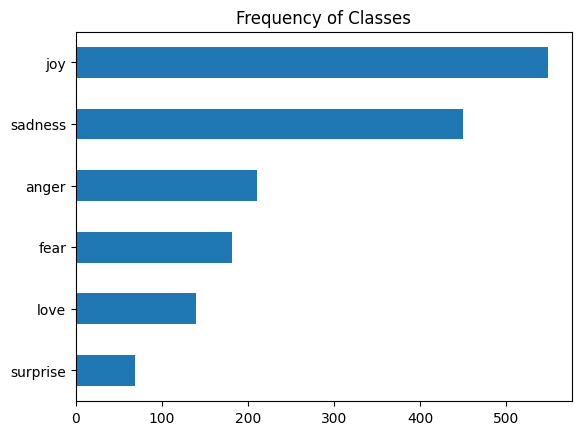

In [30]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The labels are quite unevenly distributed - we need to keep this in mind for the further analysis, but don't take any action to get a balanced dataset.

We reset the format of the dataset such that is well-suited to work with the pretrained tokenizers and models:

In [31]:
del(df) # save memory
emotions.reset_format()

## Tokenizing the Emotions Dataset
Now, we start tokenizing the dataset. We first do 2 sentences:

In [25]:
emotions["train"]['text'][:2]

0                        i love comments so feel free to post one
1    i feel super behind in all aspects of my life i need to read
Name: text, dtype: object

In [32]:
distilbert_tokenizer(emotions["train"]['text'][:2], padding=True, truncation=True)

{'input_ids': [[101, 1045, 2293, 7928, 2061, 2514, 2489, 2000, 2695, 2028, 102, 0, 0, 0, 0, 0], [101, 1045, 2514, 3565, 2369, 1999, 2035, 5919, 1997, 2026, 2166, 1045, 2342, 2000, 3191, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

We have obtained a dictionary with the keys `'input_ids'` and `'attention_mask'`. While the original two sentences have different length, the outputs have been padded with the `[PAD]` token. The `'attention_mask'` is used to ignore the `[PAD]`, i.e. the mask is 0 if the corresponding token is `[PAD]`, and 1 otherwise.

In [33]:
emotions_tok_01 = distilbert_tokenizer(emotions["train"]['text'][:2], padding=True, truncation=True)

In [34]:
distilbert_tokenizer.convert_ids_to_tokens(emotions_tok_01['input_ids'][0])

['[CLS]',
 'i',
 'love',
 'comments',
 'so',
 'feel',
 'free',
 'to',
 'post',
 'one',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [35]:
distilbert_tokenizer.convert_ids_to_tokens(emotions_tok_01['input_ids'][1])

['[CLS]',
 'i',
 'feel',
 'super',
 'behind',
 'in',
 'all',
 'aspects',
 'of',
 'my',
 'life',
 'i',
 'need',
 'to',
 'read',
 '[SEP]']

With `all_special_tokens` and `all_special_ids`, we can get all the special tokens and their IDs from the tokenizer:

In [36]:
distilbert_tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [37]:
distilbert_tokenizer.all_special_ids

[100, 102, 0, 101, 103]

Now, we will tokenize the full emotions dataset. We will again use padding, and also do truncation, i.e. we will cut off the part of the texts that is longer than `distilbert_tokenizer.model_max_length`:

In [38]:
def tokenize(batch):
    return distilbert_tokenizer(batch["text"], padding=True, truncation=True)
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

## Loading the Pretrained BERT Model
We will use the same model (`distilbert-base-uncased`) and load it from the huggingface repository. We are using `TFAutoModel`, where `TF` stands for `tensorflow`, and `AutoModel` is a class from huggingface that offers a convenient `from_pretrained()` function to get the pre-trained model weights.

In [39]:
model_ckpt = "distilbert-base-uncased"
tf_model = TFAutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Note the message that is printed as we load the pretrained weights: Some of the weights were not used. As we are using the pretrained model to obtain a suitable representation of the input strings, but not to do a complete classification, we are fine here. We will soon define the actual classification part of the model for our classification task.

Now, let us see how we can use the model to obtain the representation. To avoid an error coming from Tensorflow, we first have to enable experimental numpy-like behavior:

In [40]:
# The following command might be necessary to avoid getting an AttributeError:
# AttributeError: EagerTensor object has no attribute 'size'.
#         If you are looking for numpy-related methods, please run the following:
#         tf.experimental.numpy.experimental_enable_numpy_behavior()
tf.experimental.numpy.experimental_enable_numpy_behavior()

Now, let's define a test text, and pass that through our `distilbert_tokenizer` tokenizer. Note that we add `return_tensors="tf"` to get the input as tensorflow tensors (other return types are possible, namely `"pt"` for PyTorch, `"jax"` for JAX and `"np"` for numpy):

In [41]:
text = "this is a test"
tokenized_text = distilbert_tokenizer(text, return_tensors="tf")
print(f"tokenized_text tensor shape: {tokenized_text['input_ids'].shape}")

tokenized_text tensor shape: (1, 6)


Printing the tokenized text, we see the format is different from what we obtained without specifying the `return_tensors`:

In [42]:
tokenized_text

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}

Now, we pass the tokenized text to the model to get the represenation:

In [43]:
represented_text = tf_model(tokenized_text)
represented_text.last_hidden_state.shape

TensorShape([1, 6, 768])

The resulting tensor has have `[batch_size, n_tokens, hidden_dim]`.
Our batch consists of one line of text, consisting of 6 tokens, and we get a 768-dimensional representation for each of the tokens.

Now, we will convert the full dataset to this representation. To do so, we will add an additional column to the dataset. As our model expects tensorflow tensors, we first convert the relevant columns to this format:

In [44]:
emotions_encoded.set_format("tensorflow",
                            columns=["input_ids", "attention_mask", "label"])

We first define a helper function `extract_hidden_states`, which we will then apply to all three splits (`train`, `validation`, and `test`).

Also, for classification tasks, it is common practice to just use the hidden state associated with the `[CLS]` token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing the model output as `last_hidden_state[:, 0, :]` (all texts, first token, all dimensions).

In [45]:
def extract_hidden_states(batch):
    last_hidden_state = tf_model(batch['input_ids']).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0, :].numpy()}

Now we are ready to extract the hidden state representation for our training, validation and test set. This is best done in batched mode (as it is much faster). However, by default, the batch size is 1000, which will cause an error when run on a dataset with size that is not a multiple of the batch size (as the index will run out of the valid range for the batch that is not "full"). Hence, we have to specify the `batch_size`.

**Remark**: If you are running this notebook with tensorflow version 2.10 (which is the version in the recommended Anaconda environment) and get (multiple) error message(s) `"WARNING:tensorflow:Skipping full serialization of Keras layer ..."`: Please ignore the message - this is a well-documented issue of that version, and was resolved in the next version 2.11.

In [46]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=200)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Now, we have an additional column `'hidden_state'` containing the features that we just computed:

In [47]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Classification with Standard Approaches
In order to be able to compare the performance of the advanced models with some standard techniques, we will evaluate some off-the-shelf classification methods.

### Creating a Feature Matrix
To run standard approaches, we first extract the `'hidden_state'` into a numpy array.

In [48]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((1600, 768), (200, 768))

In [49]:
labels = emotions["train"].features["label"].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

As a first simple standard approach to classification, let's do logistic regression. While Logistic Regression is by default applicable for binary classification problems (i.e., each sample belongs to one of two classes), the scikit-learn implementation will change the loss function to cross-entropy loss and predict a multinomial probability distribution to support multi-class classification.

In [50]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.565

In [51]:
def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

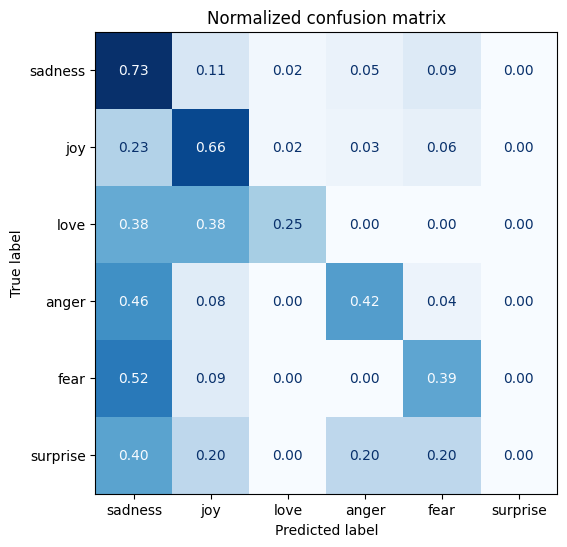

In [52]:
y_preds_lr = lr_clf.predict(X_valid)
plot_confusion_matrix(y_valid, y_preds_lr, labels)

In [53]:
bac_logreg = balanced_accuracy_score(y_valid, y_preds_lr)

As a baseline, we also use the `DummyClassifier`, which we configure to always output the most frequent class.

In [54]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.44

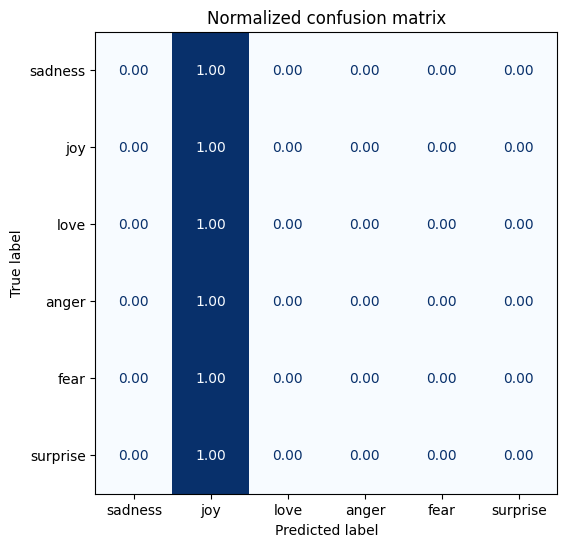

In [55]:
y_preds_dummy = dummy_clf.predict(X_valid)
plot_confusion_matrix(y_valid, y_preds_dummy, labels)

In [56]:
bac_dummy = balanced_accuracy_score(y_valid, y_preds_dummy)
bac_dummy

0.16666666666666666

In [57]:
acc_dummy = accuracy_score(y_valid, y_preds_dummy)
acc_dummy

0.44

As the category *joy* is most frequent, this classifier will always output this label.

## Fine-Tuning Transformer Models
After knowing the baseline, we want to explore how to fine-tune a transformer end-to-end. Doing so, we no longer use the hidden features as fixed inputs, but optimize them together with the classification head in order to obtain the best performance for the given task. We therefore need a differentiable classification head, which is why in such a context, neural networks are usually used also for classification.

We will again use an `AutoModel` to load the pretrained DistilBERT model, but will use the more specific `AutoModelForSequenceClassification`. As the support for TensorFlow is limited, we will mostly work with the PyTorch implementation, but show the code in TensorFlow below.

In [64]:
import keras
#from keras.optimizers import adam
# Fine-Tuning using TensorFlow
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=NUM_LABELS)

opt = keras.optimizers.Adam(learning_rate=5e-5)
# The column names to convert to TensorFlow tensors
tokenizer_columns = distilbert_tokenizer.model_input_names

# Prepare datasets in TF format
tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=BATCH_SIZE)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=BATCH_SIZE)

# compile and fit the tf_model

tf_model.compile(
    optimizer='adam',#tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model_history = tf_model.fit(tf_train_dataset,
                                validation_data=tf_eval_dataset, epochs=20,
                                callbacks = [ EarlyStopping(monitor='val_sparse_categorical_accuracy',
                                                            patience=5,
                                                            verbose=False,
                                                            restore_best_weights=True)])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/20


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - 65s 710ms/step - loss: 1.6534 - sparse_categorical_accuracy: 0.3052 - val_loss: 1.5233 - val_sparse_categorical_accuracy: 0.3352
Epoch 2/20
25/25 [==============================] - 11s 432ms/step - loss: 1.6042 - sparse_categorical_accuracy: 0.3378 - val_loss: 1.5165 - val_sparse_categorical_accuracy: 0.3416
Epoch 3/20
25/25 [==============================] - 11s 442ms/step - loss: 1.5985 - sparse_categorical_accuracy: 0.3447 - val_loss: 1.5491 - val_sparse_categorical_accuracy: 0.3437
Epoch 4/20
25/25 [==============================] - 11s 426ms/step - loss: 1.5993 - sparse_categorical_accuracy: 0.3454 - val_loss: 1.5354 - val_sparse_categorical_accuracy: 0.3453
Epoch 5/20
25/25 [==============================] - 11s 419ms/step - loss: 1.5927 - sparse_categorical_accuracy: 0.3441 - val_loss: 1.5290 - val_spar

In [65]:
# save weights
tf_model.save_weights('model_feelingClassi_pretrained_weights')
with open('model_feelingClassi_pretrained_Results.pkl', 'wb') as f:
    pickle.dump(tf_model_history, f)

# copy to google drive
if use_colab:
    %cp model_feelingClassi_pretrained_weights* $targetDir_models
    %cp model_feelingClassi_pretrained_Results* $targetDir_results

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


cp: target 'gdrive/MyDrive/CAS_AIS_2024_FS/Results/trainedWeights/' is not a directory
cp: cannot create regular file 'gdrive/MyDrive/CAS_AIS_2024_FS/Results/PerformanceMeasures/': No such file or directory


4/4 [==============================] - 4s 92ms/step


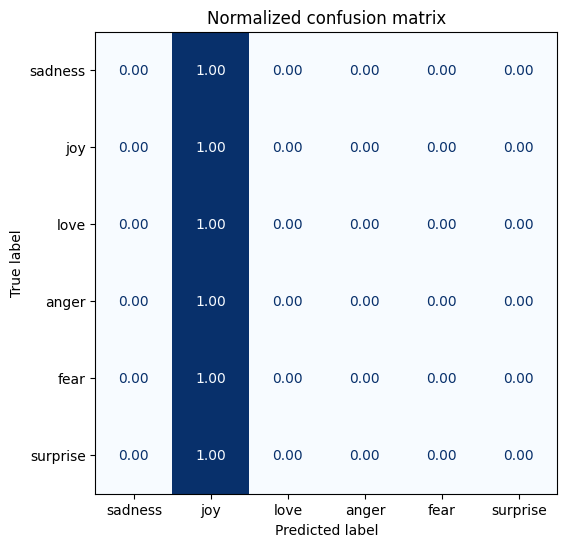

In [66]:
# predictions on validation data, and plot confusion matrix.
preds_output = tf_model.predict(tf_eval_dataset)
preds_ouput_binary = preds_output.logits.argmax(axis=1)
plot_confusion_matrix(y_valid, preds_ouput_binary, labels)

In [67]:
bac_ft_tf = balanced_accuracy_score(y_valid, preds_ouput_binary)
bac_ft_tf

0.16666666666666666

### Fine-Tuning using Trainer
Besides steering the fine-tuning directly in Tensorflow, we can also use the `Trainer` class (provided by huggingface), which abstracts away most of the technical details:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=NUM_LABELS)
         .to(device))

Nex, we have to define a function to compute the metrics. This function will be used for the `Trainer`, a class (from huggingface) that steers the fine-tuning of the model.

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    return {"accuracy": acc, "balanced accuracy": bac, "f1": f1}

Huggingface offers a hub, where trained models can be stored for later use. The `notebook_login` allows us to authenticate and afterwards store (commit) models directly from this notebook. If you do not have a huggingface account, you can create one at https://huggingface.co/

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`. Therefore, we had to update the `accelerate` in the beginning of the notebook. We first specify the training parameters:

In [ ]:
logging_steps = len(emotions_encoded["train"]) // BATCH_SIZE
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=20,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # set to True to use your model afterwards:
                                  push_to_hub=False,
                                  log_level="error")

Now, we can use the `Trainer` class to train the model with the specified parameters:

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=distilbert_tokenizer)
trainer.train();

Accuracy and F1-score are computed on the validation data. Note that the data set is -- in comparison to the model complexity -- very small and might cause our model to start to overfit.

We can now evaluate the performance of the fine-tuned model on the validation set:

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

To get a more detailed view on the classification performance, we also look at the confusion matrix:

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_valid, y_preds, labels)

In [ ]:
bac_ft_pt = balanced_accuracy_score(y_valid, y_preds)
bac_ft_pt

We see that the category *love* are quite often confused with *joy*, which seems natural. *sadness* is the categories that is best recognised. All in all, the

Before we look at the results in more detail, we push the fine-tuned model onto the huggingface hub. Note that this only works if
* you have set a token for the notebook, and
* you have set `push_to_hub=True` in the `TrainingParameters`

In [ ]:
# trainer.push_to_hub(commit_message="Training completed!")

## Error Analysis
In order to better understand the performance of our model, we will investigate some samples of the validation data set. More specifically, we will look at the examples where the loss was particularly high or low.

To get the loss, we run the model again on the sentences, and then calculate the estimated label and the cross-entropy.

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in distilbert_tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

We convert the emotions dataframe to pandas, and convert the numerical categories to text labels:

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Now, we can look at the 10 examples with the highest loss:

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

Conversely, here are the 10 examples with lowest loss - i.e., where the model is most confident about its prediction:

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

## Re-Using our Fine-Tuned Model

If we have stored the model on the huggingface hub, we can very easily fetch it and use it for a further classification:

In [ ]:
from transformers import pipeline

# Change to your Hub username
model_id = "andreas-in-den-bergen/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Here we classify our sample text (`custom_tweet`) "I saw a movie today and it was really good.":

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()